In [53]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from loguru import logger
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

Let's load the parquetfile we saved in notebook 1. You will need to change the filename in the config file!

In [54]:
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)
config

{'raw': 'data/raw',
 'processed': 'data/processed',
 'input': '_chat.txt',
 'current': 'whatsapp-20250910-002822-maap-cleaned.parq',
 'current_1': 'whatsapp-20250910-004727-golf-cleaned.parq',
 'current_2': 'whatsapp-20250910-012654-voorganger-golf-cleaned.parq',
 'inputpath': 'whatsapp-20250910-001356-maap.csv',
 'datetime_format': '%d-%m-%Y, %H:%M:%S',
 'drop_authors': []}

In [55]:
root = Path("..").resolve()
processed = root / Path(config["processed"])
datafile = processed / config["current"]
if not datafile.exists():
    logger.warning(
        f"{datafile} does not exist. First run src/preprocess.py, and check the timestamp!"
    )

Note how datatypes have been preserved.

In [56]:
df = pd.read_parquet(datafile)
df.dtypes

timestamp    datetime64[ns, UTC]
author                    object
message                   object
has_emoji                   bool
dtype: object

In [57]:
df.head()

,timestamp,author,message,has_emoji
0,2015-11-04 11:28:12+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft deze groep gemaakt,False
1,2016-11-15 00:34:50+00:00,MAAP,‎Phons Berkemeijer heeft je toegevoegd,False
2,2016-11-15 00:35:04+00:00,MAAP,‎Berichten en oproepen worden end-to-end versl...,False
3,2017-03-31 11:58:33+00:00,Phons Berkemeijer,‎Locatie: https://maps.google.com/?q=51.378368...,False
4,2018-05-01 21:31:07+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[13-05-2018, 15:0...",False


In [102]:
import pandas as pd

# Filter out "MAAP"
df = df.loc[df["author"] != "MAAP"]
df = df.reset_index(drop=True)# Convert timestamp to datetime if it's not already

import pandas as pd

# Ensure timestamp is datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Extract date
df["date"] = df["timestamp"].dt.date

# Step 1: Count messages per day
daily_counts = df.groupby("date").size().reset_index(name="message_count")

# Step 2: Add year column
daily_counts["year"] = pd.to_datetime(daily_counts["date"]).dt.year

# Step 3: Define frequency buckets and labels
freq_ranges = [0, 5, 10, 20, float("inf")]
categories = ["some", "more", "intense", "crazy"]

# Step 4: Categorize message volume
daily_counts["volume_category"] = pd.cut(
    daily_counts["message_count"],
    bins=freq_ranges,
    labels=categories,
    right=False
)

# Step 5: Count number of days per category per year
summary = (
    daily_counts.groupby(["year", "volume_category"])
    .size()
    .reset_index(name="day_count")
    .pivot(index="year", columns="volume_category", values="day_count")
    .fillna(0)
    .astype(int)
)

# Step 6: Reindex to include all years from 2015 to 2025
all_years = pd.Index(range(2019, 2026), name="year")
summary = summary.reindex(all_years, fill_value=0)

# Step 7: Print summary
print("Summary: Number of Days per Category per Year")
print(summary)

# Step 1: Filter for "crazy" days only
crazy_days_all = daily_counts[daily_counts["volume_category"] == "crazy"].copy()

# Step 2: Get all messages on those dates
crazy_dates = crazy_days_all["date"].unique()
crazy_messages = df[df["date"].isin(crazy_dates)]

# Step 3: Count messages per author per date
author_counts = (
    crazy_messages.groupby(["date", "author"])
    .size()
    .reset_index(name="author_message_count")
)

# Step 4: Pivot so each author becomes a column
author_pivot = author_counts.pivot(index="date", columns="author", values="author_message_count").fillna(0).astype(int)

# Step 5: Merge with crazy_days_all
crazy_days_enriched = crazy_days_all.merge(author_pivot, on="date", how="left")

# Step 6: Save to CSV
crazy_days_enriched.sort_values(["year", "date"]).to_csv(
    r"c:\Users\avtnl\Documents\HU\Data Analytics\My_Project\crazy_days_by_year_enriched.csv",
    index=False
)



Summary: Number of Days per Category per Year
volume_category  some  more  intense  crazy
year                                       
2019               22    12        2      3
2020               28    36       14     12
2021               39    22       23     10
2022               23    23        8      4
2023               43    26        9      2
2024               41    24       16      5
2025               29    18       10      3


Let's count the amount of messages, per author.

In [103]:
# Step 1: Get all messages by Anthony
df["date"] = df["timestamp"].dt.date
anthony_msgs = df[df["author"] == "Anthony van Tilburg"]

# Step 2: Count Anthony's messages per day
anthony_counts = anthony_msgs.groupby("date").size().reset_index(name="anthony_count")

# Step 3: Merge with daily_counts
daily_counts = daily_counts.merge(anthony_counts, on="date", how="left")
daily_counts["anthony_count"] = daily_counts["anthony_count"].fillna(0).astype(int)

# Step 4: Create flags for zero participation
daily_counts["anthony_zero"] = daily_counts["anthony_count"] == 0

# Step 5: Count zero-participation days per category per year
zero_summary = (
    daily_counts[daily_counts["anthony_zero"]]
    .groupby(["year", "volume_category"])
    .size()
    .reset_index(name="zero_days")
    .pivot(index="year", columns="volume_category", values="zero_days")
    .fillna(0)
    .astype(int)
)

# Step 6: Reindex to include all years
zero_summary = zero_summary.reindex(all_years, fill_value=0)

# Step 7: Rename columns
zero_summary.columns = [f"{col}-AvT" for col in zero_summary.columns]

# Step 8: Display the new summary
print("📊 Days with Zero Participation by Anthony van Tilburg")
print(zero_summary)


📊 Days with Zero Participation by Anthony van Tilburg
      some-AvT  more-AvT  intense-AvT  crazy-AvT
year                                            
2019        19         8            2          2
2020        24        19            6          5
2021        33        14           15          4
2022        18        15            4          2
2023        32        11            4          1
2024        37        10            9          3
2025        22         6            2          1


In [104]:
# Step 1: Original summary (total days per category per year)
summary = (
    daily_counts.groupby(["year", "volume_category"])
    .size()
    .reset_index(name="day_count")
    .pivot(index="year", columns="volume_category", values="day_count")
    .fillna(0)
    .astype(int)
)

summary = summary.reindex(all_years, fill_value=0)

# Step 2: Zero-participation summary
zero_summary = (
    daily_counts[daily_counts["anthony_zero"]]
    .groupby(["year", "volume_category"])
    .size()
    .reset_index(name="zero_days")
    .pivot(index="year", columns="volume_category", values="zero_days")
    .fillna(0)
    .astype(int)
)

zero_summary = zero_summary.reindex(all_years, fill_value=0)
zero_summary.columns = [f"{col}-AvT" for col in zero_summary.columns]

# Step 3: Compute percentage of zero-participation days
percentage_summary = (zero_summary.values / summary.values * 100).round(1)
percentage_df = pd.DataFrame(
    percentage_summary,
    index=summary.index,
    columns=[f"{col}-AvT%" for col in summary.columns]
)

# Step 4: Display the percentage summary
print("📊 Percentage of Days with Zero Participation by Anthony van Tilburg")
print(percentage_df)


📊 Percentage of Days with Zero Participation by Anthony van Tilburg
      some-AvT%  more-AvT%  intense-AvT%  crazy-AvT%
year                                                
2019       86.4       66.7         100.0        66.7
2020       85.7       52.8          42.9        41.7
2021       84.6       63.6          65.2        40.0
2022       78.3       65.2          50.0        50.0
2023       74.4       42.3          44.4        50.0
2024       90.2       41.7          56.2        60.0
2025       75.9       33.3          20.0        33.3


In [107]:
# Define authors and their short labels
authors = {
    "Anthony van Tilburg": "AvT",
    "Anja Berkemeijer": "AB",
    "Phons Berkemeijer": "PB",
    "Madeleine": "M"
}

# Create a copy of daily_counts to start
daily_counts_extended = daily_counts.copy()

# Initialize dictionary to hold each author's zero-participation summary
zero_summaries = {}

for full_name, label in authors.items():
    # Step 1: Filter messages by author
    author_msgs = df[df["author"] == full_name]

    # Step 2: Count messages per day
    author_counts = author_msgs.groupby("date").size().reset_index(name=f"{label}_count")

    # Step 3: Merge with daily_counts
    daily_counts_extended = daily_counts_extended.merge(author_counts, on="date", how="left")
    daily_counts_extended[f"{label}_count"] = daily_counts_extended[f"{label}_count"].fillna(0).astype(int)

    # Step 4: Flag zero participation
    daily_counts_extended[f"{label}_zero"] = daily_counts_extended[f"{label}_count"] == 0

    # Step 5: Count zero-participation days per category per year
    zero_summary = (
        daily_counts_extended[daily_counts_extended[f"{label}_zero"]]
        .groupby(["year", "volume_category"])
        .size()
        .reset_index(name="zero_days")
        .pivot(index="year", columns="volume_category", values="zero_days")
        .fillna(0)
        .astype(int)
    )

    # Step 6: Reindex to include all years
    zero_summary = zero_summary.reindex(all_years, fill_value=0)

    # Step 7: Rename columns
    zero_summary.columns = [f"{col}-{label}" for col in zero_summary.columns]

    # Store for later merge
    zero_summaries[label] = zero_summary

# Step 8: Combine all summaries into one DataFrame
combined_zero_summary = pd.concat(zero_summaries.values(), axis=1)

# Step 9: Display each author's zero-participation summary separately
for label, summary_df in zero_summaries.items():
    print(f"\n📊 Days with Zero Participation — {label}")
    print(summary_df)

# Step 10: Save each author's table to a separate CSV file
for label, summary_df in zero_summaries.items():
    file_path = fr"c:\Users\avtnl\Documents\HU\Data Analytics\My_Project\zero_participation_{label}.csv"
    summary_df.to_csv(file_path, index=True)
    print(f"✅ Saved: {file_path}")




📊 Days with Zero Participation — AvT
      some-AvT  more-AvT  intense-AvT  crazy-AvT
year                                            
2019        19         8            2          2
2020        24        19            6          5
2021        33        14           15          4
2022        18        15            4          2
2023        32        11            4          1
2024        37        10            9          3
2025        22         6            2          1

📊 Days with Zero Participation — AB
      some-AB  more-AB  intense-AB  crazy-AB
year                                        
2019       11        3           0         0
2020       11        8           1         2
2021       24        3           2         0
2022        9        5           1         0
2023       17        2           0         0
2024       17        5           3         0
2025       15        5           0         0

📊 Days with Zero Participation — PB
      some-PB  more-PB  intense-PB  crazy-

C:\Users\avtnl\AppData\Local\Temp\ipykernel_32124\4222519779.py:84: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



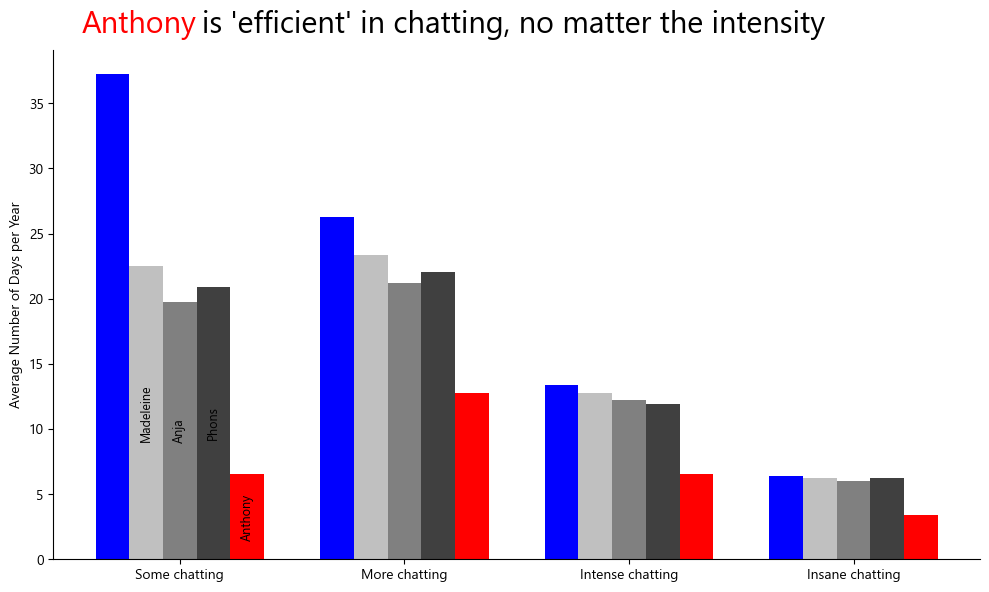

In [144]:
import matplotlib.pyplot as plt

# Normalize factor
years_span = 6.125

# Step 1: Total days per category
total_days = (
    daily_counts.groupby("volume_category")
    .size()
    .reindex(["some", "more", "intense", "crazy"])
) / years_span

# Step 2: Participation days per author
ordered_labels = ["M", "AB", "PB", "AvT"]
author_participation = {}

for label in ordered_labels:
    zero_days = (
        daily_counts_extended[daily_counts_extended[f"{label}_zero"]]
        .groupby("volume_category")
        .size()
        .reindex(["some", "more", "intense", "crazy"])
        .fillna(0)
    ) / years_span
    participation_days = total_days - zero_days
    author_participation[label] = participation_days

# Step 3: Build DataFrame
df_plot = pd.DataFrame(author_participation)
df_plot.insert(0, "Total Days", total_days)
df_plot = df_plot[["Total Days", "M", "AB", "PB", "AvT"]]  # Ensure order
categories = df_plot.index.tolist()

# Step 4: Plot setup
fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.15
x = range(len(categories))

# Plot Total Days (black)
ax.bar([i - 2*bar_width for i in x], df_plot["Total Days"], width=bar_width, color="blue")

# Plot Madeleine (light green)
bars_M = ax.bar([i - bar_width for i in x], df_plot["M"], width=bar_width, color="#C0C0C0")  # light gray

# Plot Anja (green)
bars_AB = ax.bar(x, df_plot["AB"], width=bar_width, color="#808080") # gray

# Plot Phons (dark green)
bars_PB = ax.bar([i + bar_width for i in x], df_plot["PB"], width=bar_width, color="#404040")  # dark gray

# Plot Anthony (red)
bars_AvT = ax.bar([i + 2*bar_width for i in x], df_plot["AvT"], width=bar_width, color="red")

# Step 5: Add names inside bars for "some" category
some_index = categories.index("some")
bar_positions = [
    some_index - bar_width,  # M
    some_index,              # AB
    some_index + bar_width,  # PB
    some_index + 2*bar_width # AvT
]
names = ["Madeleine", "Anja", "Phons", "Anthony"]
for pos, name, height in zip(bar_positions, names, [df_plot.loc["some", lbl] for lbl in ordered_labels]):
    ax.text(pos, height / 2, name, ha="center", va="center", color="black", fontsize=9, rotation="vertical")

# Step 6: Final touches
custom_labels = {
    "some": "Some chatting",
    "more": "More chatting",
    "intense": "Intense chatting",
    "crazy": "Insane chatting"
}
ax.set_xticks(x)
ax.set_xticklabels([custom_labels[cat] for cat in categories])
ax.set_ylabel("Average Number of Days per Year")
ax.text(0.03, 1.05, "Anthony", transform=ax.transAxes,
        ha="left", va="center", fontsize=22, color="red")
ax.text(0.16, 1.05, "is 'efficient' in chatting, no matter the intensity",
        transform=ax.transAxes, ha="left", va="center", fontsize=22, color="black")
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=10)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend().set_visible(False)  # Remove legend

plt.tight_layout()
plt.show()



In [ ]:
# Filter out "MAAP"
df = df.loc[df["author"] != "MAAP"]
df = df.reset_index(drop=True)

p1 = (
    df[["author", "message"]]
    .groupby("author")
    .count()
    .sort_values("message", ascending=False)
)

k = 15
topk = p1[:k]


In [67]:
topk_authors = list(topk.index)

In [68]:
df["is_topk"] = df["author"].apply(lambda x: x in topk_authors)
df.head()

,timestamp,author,message,has_emoji,is_topk
0,2015-11-04 11:28:12+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft deze groep gemaakt,False,True
1,2017-03-31 11:58:33+00:00,Phons Berkemeijer,‎Locatie: https://maps.google.com/?q=51.378368...,False,True
2,2018-05-01 21:31:07+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[13-05-2018, 15:0...",False,True
3,2019-04-07 19:35:25+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[31-05-2019, 19:2...",False,True
4,2019-08-04 13:39:20+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft de groepsafbeelding g...,False,True


Text(0.5, 1.0, 'Sending the most messages...')

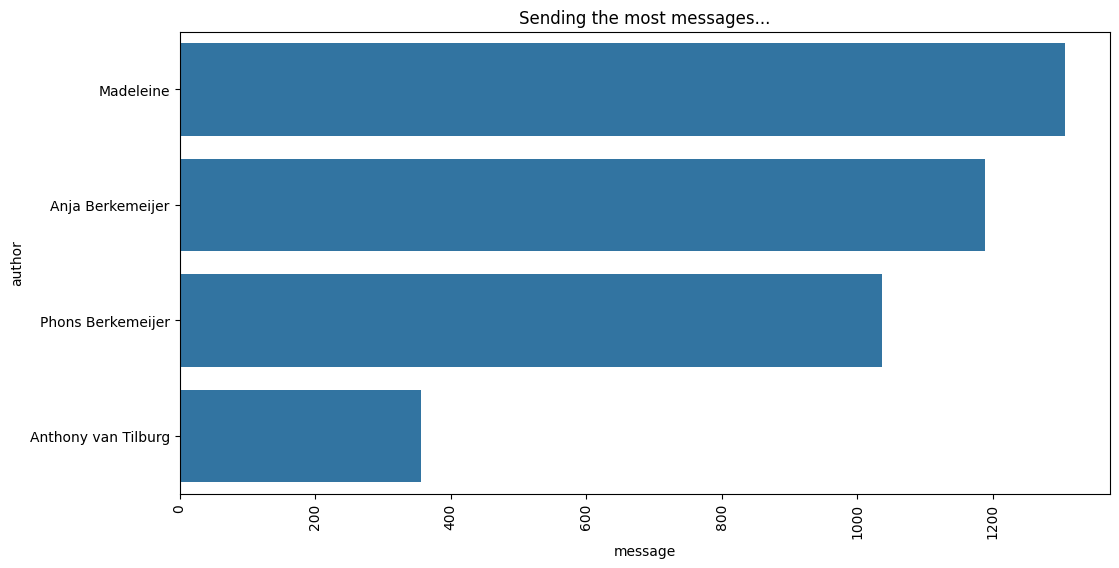

In [69]:
plt.figure(figsize=(12, 6))
sns.barplot(y=p1.index[:k], x="message", data=topk)
plt.xticks(rotation=90)
plt.title("Sending the most messages...")

Maybe tweak the colors a bit

Text(0.5, 1.0, 'Sending the most messages...')

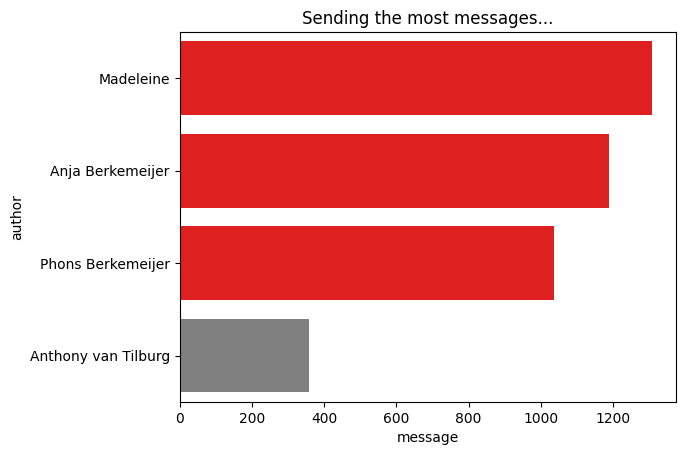

In [70]:
colors = [0 if x < 1000 else 1 for x in topk.message]
custom_palette = {0: "grey", 1: "red"}
sns.barplot(
    y=p1.index[:k],
    x="message",
    hue=colors,
    data=topk,
    palette=custom_palette,
    legend=False,
)
plt.title("Sending the most messages...")

Let's calculate the average message length.

Text(0.5, 1.0, 'Sending the longest messages...')

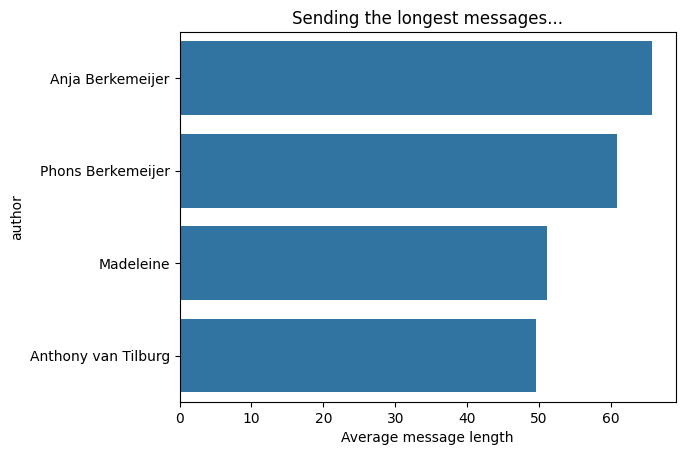

In [71]:
df["message_length"] = df["message"].str.len()
p1 = (
    df[["author", "message_length"]]
    .groupby("author")
    .mean()
    .sort_values("message_length", ascending=False)
)
k = 15
topk = p1[:k]
sns.barplot(y=p1.index[:k], x="message_length", data=topk)
plt.xlabel("Average message length")
plt.title("Sending the longest messages...")

Create a simple regex to look for links in the messages and add that as a feature:

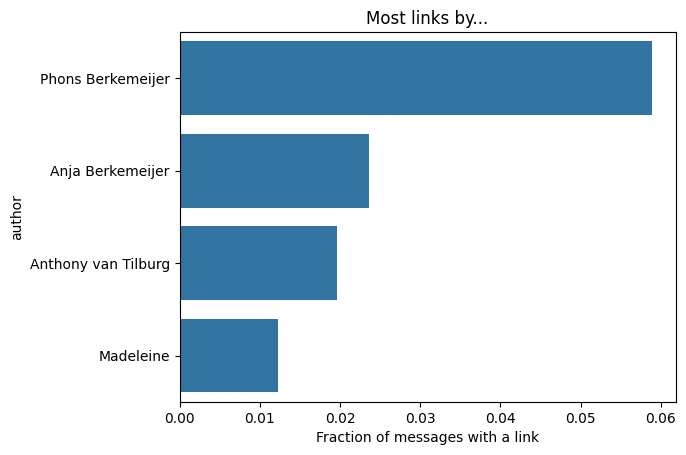

In [72]:
has_link = r"http"
df["has_link"] = df["message"].str.contains(has_link)
if df["has_link"].sum() > 0:
    p1 = (
        df[["author", "has_link"]]
        .groupby("author")
        .mean()
        .sort_values("has_link", ascending=False)
    )

    k = 15
    topk = p1[:k]
    sns.barplot(y=p1.index[:k], x="has_link", data=topk)
    plt.xlabel("Fraction of messages with a link")
    plt.title("Most links by...")
else:
    logger.info("No links found in the messages")

Aggregate the emojis per user (can you change between sum and mean?)

Text(0.5, 1.0, "Are emoji's non-verbal?")

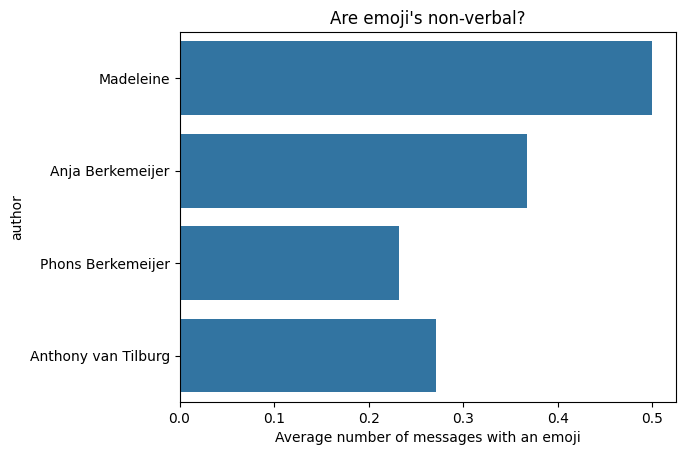

In [73]:
p2 = (
    df[["author", "has_emoji"]]
    .groupby("author")
    .agg(["sum", "mean"])
    .sort_values(("has_emoji", "sum"), ascending=False)
)

p2.columns = p2.columns.droplevel(0)
topk = p2[:k]
sns.barplot(y=p2.index[:k], x="mean", data=topk)
plt.xlabel("Average number of messages with an emoji")
plt.title("Are emoji's non-verbal?")

Let's add a cateory, based on the time when authors send a message:

In [74]:
import pandas as pd

# Define the time ranges
time_ranges = ["00:00", "06:00", "08:00", "17:30", "22:00", "23:59"]
# Define the category labels
categories = ["night", "morning", "worktimes", "evening", "late"]
# Categorize the timestamp column
df["timestamp_category"] = pd.cut(
    df["timestamp"].dt.time.astype(str),
    bins=time_ranges,
    labels=categories,
    right=False,
)
# Display the updated dataframe
df

,timestamp,author,message,has_emoji,is_topk,message_length,has_link,timestamp_category
0,2015-11-04 11:28:12+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft deze groep gemaakt,False,True,43,False,worktimes
1,2017-03-31 11:58:33+00:00,Phons Berkemeijer,‎Locatie: https://maps.google.com/?q=51.378368...,False,True,2972,True,worktimes
2,2018-05-01 21:31:07+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[13-05-2018, 15:0...",False,True,4997,False,evening
3,2019-04-07 19:35:25+00:00,Phons Berkemeijer,"‎Dit bericht is verwijderd. ‎[31-05-2019, 19:2...",False,True,1226,False,evening
4,2019-08-04 13:39:20+00:00,Phons Berkemeijer,‎Phons Berkemeijer heeft de groepsafbeelding g...,False,True,54,False,worktimes
...,...,...,...,...,...,...,...,...
3883,2025-09-04 18:17:57+00:00,Anthony van Tilburg,Alleen moeten we dan voor Anja een zeecontaine...,True,True,57,False,evening
3884,2025-09-04 18:18:05+00:00,Phons Berkemeijer,😂😂,True,True,2,False,evening
3885,2025-09-04 18:19:11+00:00,Anja Berkemeijer,Ik koop daar wel,False,True,16,False,evening
3886,2025-09-04 18:19:23+00:00,Phons Berkemeijer,1 is wel krap dan,False,True,17,False,evening


Now we can group and count the categories:

In [75]:
# Group the dataframe by 'author' and 'timestamp_category', and count the occurrences
p3 = df.groupby(["author", "timestamp_category"]).size().unstack()

# Calculate the fraction of each category for every author
p3_frac = p3.div(p3.sum(axis=1), axis=0)
p3_frac

timestamp_category,night,morning,worktimes,evening,late
author,,,,,
Anja Berkemeijer,0.025274,0.005897,0.500421,0.342881,0.125527
Anthony van Tilburg,0.019608,0.002801,0.456583,0.338936,0.182073
Madeleine,0.028309,0.009946,0.539403,0.316756,0.105585
Phons Berkemeijer,0.034816,0.004836,0.544487,0.307544,0.108317


Let's use plotly the create a stacked bar chart:

In [76]:
p4 = p3_frac.reset_index().melt(id_vars="author")
p4.head()

,author,timestamp_category,value
0,Anja Berkemeijer,night,0.025274
1,Anthony van Tilburg,night,0.019608
2,Madeleine,night,0.028309
3,Phons Berkemeijer,night,0.034816
4,Anja Berkemeijer,morning,0.005897


In [77]:
p4_filtered = p4[p4["author"].isin(topk_authors)]

In [78]:
import plotly.express as px

fig = px.bar(
    p4_filtered, y="author", x="value", color="timestamp_category", barmode="stack"
)
fig.show()

Let's extract the minimum and maximum time of the messages for every author, and convert that to a decimal fraction:

In [89]:
df["hour"] = df["timestamp"].dt.time
summary_df = df.groupby("author")["hour"].agg(["min", "max"]).reset_index()


def convert_to_decimal_hours(timestamp):
    dec_hour = timestamp.hour + timestamp.minute / 60 + timestamp.second / 3600
    return dec_hour


summary_df["min_x_values"] = summary_df["min"].apply(convert_to_decimal_hours)
summary_df["max_x_values"] = summary_df["max"].apply(convert_to_decimal_hours)

# Drop the original 'min' and 'max' columns as they are no longer needed
summary_df = summary_df.drop(["min", "max"], axis=1)
summary_df.head()


,author,min_x_values,max_x_values
0,Anja Berkemeijer,0.023611,23.995000
1,Anthony van Tilburg,0.061389,23.952778
2,Madeleine,0.033056,23.917500
3,Phons Berkemeijer,0.014444,23.991944


With this, we can create a nice barbell chart. Try to add colors for your own chart!

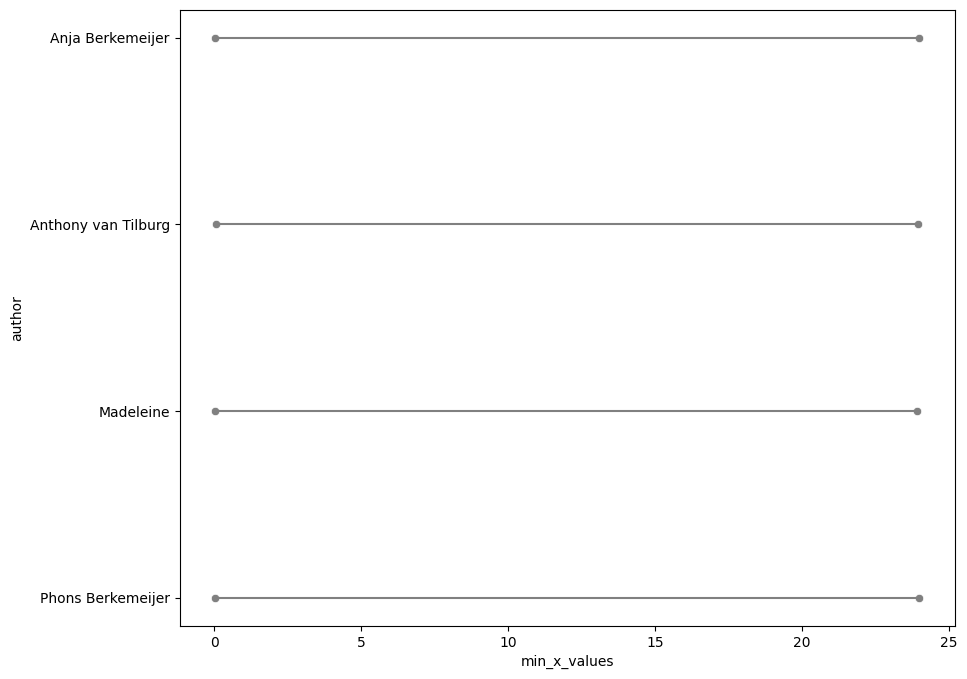

In [80]:
# Create a larger plot
plt.figure(figsize=(10, 8))

# Create scatter plots
sns.scatterplot(data=summary_df, x="min_x_values", y="author", color="grey")
sns.scatterplot(data=summary_df, x="max_x_values", y="author", color="grey")

# Add lines
for index, row in summary_df.iterrows():
    plt.plot(
        [row["min_x_values"], row["max_x_values"]],
        [row["author"], row["author"]],
        color="grey",
    )


# Adjust the font size of the y-axis labels if needed
plt.yticks(fontsize=10)

# Show the plot
plt.show()

Another approach for comparing is to create a heatmap:

Text(0.5, 1.0, 'Heatmap')

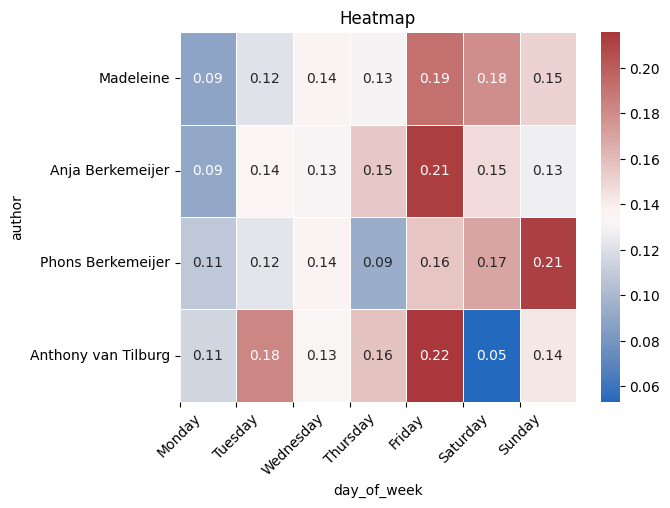

In [81]:
df["day_of_week"] = df["timestamp"].dt.dayofweek
author_day_counts = df.groupby(["author", "day_of_week"]).size().unstack(fill_value=0)
author_day_percentages = author_day_counts.div(author_day_counts.sum(axis=1), axis=0)


filtered = author_day_percentages.loc[topk_authors]
sns.heatmap(filtered, annot=True, fmt=".2f", linewidths=0.5, cmap="vlag")
plt.xticks(
    ticks=range(7),
    labels=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ],
    rotation=45,
)
plt.title("Heatmap")

Let's save all the new features we added:

In [82]:
datafile

WindowsPath('C:/Users/avtnl/Documents/HU/Data Analytics/My_Project/data/processed/whatsapp-20250910-002822-maap-cleaned.parq')

In [83]:
df.to_parquet(datafile, index=False)